# Chapter 4. Fine-Tuning the Echo State Network

In this chapter you will learn how to tune ESN parameters and hyperparameters to maximize ESN performance.

## Introduction

Let's revisit the ESN setup for solving NARMA10 and list its parameters.
We consider the task where an input $u[k] \sim \mathcal{U}([-1,1])$ is linearly projected into an ESN and the NARMA10 series $y[k]$ is reconstructed from the reservoir state $x[k]$.
The following parameters appear in this setup:

- $v[k] = \sigma u[k] + \phi$
  - $\sigma \in \mathbb{R}$: Input scale
  - $\phi \in \mathbb{R}$: Bias
- $x[k+1] = (1-a)~x[k] + a~\tanh\left(\rho W^\mathrm{rec} x[k] + W^\mathrm{in} v[k+1]\right)$
  - $N \in \mathbb{Z}^+$: Number of ESN nodes
  - $\rho \in \mathbb{R}^+$: Spectral radius
  - $a \in \mathbb{R}^+$: Leaky rate
  - $x[0]$: Initial state of ESN
- $y[k+1] = \mathrm{NARMA10}(\nu[k], \nu[k-9],~y[k],~\ldots,~y[k-9]; \alpha, \beta, \gamma, \delta),~\nu[k] = \mu u[k] + \kappa$
  - $\alpha, \beta, \gamma, \delta \in \mathbb{R}$: Function parameters
  - $\mu, \kappa \in \mathbb{R}$: Scaling parameters
- Miscellaneous
  - $T_\mathrm{washout} \in \mathbb{Z}^+$: Total time steps of washout
  - $T_\mathrm{train} \in \mathbb{Z}^+$: Total time steps of training data
  - $T_\mathrm{eval} \in \mathbb{Z}^+$: Total time steps of evaluation (validation) data

For a fair comparison, we fix the parameters of the target NARMA10 to typical values $(\alpha,\beta,\gamma,\delta,\mu,\kappa)=(0.3,0.05,1.5,0.1,0.25,0.25)$, and use the same input $u[k]$ and the corresponding time series $y[k]$ in the following runs.
Below, we will optimize the remaining important parameters individually or collectively: input scaling $(\sigma, \phi)$, ESN parameters $(N, \rho, a)$, and the length of training data $T_\mathrm{train}$.

## Exercises and demonstrations

We now move to exercises and demonstrations.
You can import the previously implemented `ESN`, `Linear`, and `narma_func` here as before.
Please run the next cell first.
If you want to inspect their implementations, uncomment the lines after `import inspect` or use `...?? / ??...`.

In [ ]:
import itertools
import sys

import numpy as np
import scipy.optimize

if "google.colab" in sys.modules:
    from google.colab import drive  # type: ignore

    if False:  # Set to True if you want to use Google Drive and save your work there.
        drive.mount("/content/gdrive")
        %cd /content/gdrive/My Drive/rc-bootcamp/
        # NOTE: Change it to your own path if you put the zip file elsewhere.
        # e.g., %cd /content/gdrive/My Drive/[PATH_TO_EXTRACT]/rc-bootcamp/
    else:
        pass
        %cd /content/
        !git clone --branch en https://github.com/rc-bootcamp/rc-bootcamp.git
        %cd /content/rc-bootcamp/
else:
    sys.path.append(".")

from utils.reservoir import ESN, Linear
from utils.style_config import Figure, plt
from utils.task import narma_func
from utils.tester import load_from_chapter_name
from utils.tqdm import tqdm, trange

test_func, show_solution = load_from_chapter_name("04_esn_fine_tuning")

# Uncomment it to see the implementations of `Linear` and `ESN`.
# import inspect
# print(inspect.getsource(Linear))
# print(inspect.getsource(ESN))
# print(inspect.getsource(narma_func))

# Or just use ??.../...?? (uncomment the following lines).
# Linear??
# ESN??
# narma_func??

### 1. Preparation and batch processing

From here, we will repeat similar operations over many related datasets.
As preparation, we extend `LRReadout` and `calc_nrmse` so they can perform linear regression and calculation of NRMSE on multiple datasets at once, giving `BatchLRReadout` and `calc_batch_nrmse`.
This kind of batch processing is straightforward in NumPy once you get the broadcasting patterns right.
It often outperforms explicit Python loops due to vectorized operations.

Q1.1.

As learned previously, for the predictor matrix $\tilde{X}=[1 : X]\in\mathbb{R}^{T\times (N+1)}$ (with an added bias column) and the target sequence $Y\in \mathbb{R}^{T \times D}$, the weights $\hat{w}\in\mathbb{R}^{(N+1)\times D}$ that minimize $\|Xw - Y\|^2$ are given by

$$
\renewcommand{\Rho}{\mathrm{P}}
\begin{align*}
\hat{w} &= (\tilde{X}^\top \tilde{X})^{-1}{\tilde{X}}^\top Y \\
&=\tilde{X}^+ Y
.\end{align*}
$$

However, due to the specifications of [`np.linalg.lstsq`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html), the previously implemented `LRReadout` cannot take multidimensional arrays $X\in\mathbb{R}^{... \times T \times (N+1)},~Y\in \mathbb{R}^{... \times T \times D}$ as arguments to obtain $\hat{w}^\mathrm{out} \in \mathbb{R}^{...\times (N+1) \times D}$ in batch processing.
On the other hand, [`np.linalg.pinv`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) allows for input of multidimensional arrays $A\in\mathbb{R}^{...\times M \times N}$, returning the pseudo-inverse $A^+\in\mathbb{R}^{...\times N \times M}$.
Based on the above equation and the answers from the previous chapter, fill in the blanks in the following code to complete `BatchLRReadout`, which enables batch processing for linear regression.

- `BatchLRReadout.train`
  - Argument(s):
    - `x`: `np.ndarray`
      - `shape`: `(..., time_steps, input_dim)`
    - `y`: `np.ndarray`
      - `shape`: `(..., time_steps, output_dim)`
  - Return(s):
    - `self.weight`: `np.ndarray`
      - `shape`: `(..., output_dim, input_dim)`
    - `self.bias`: `np.ndarray`
      - `shape`: `(..., 1, output_dim)`

  - Operation(s):
      - Update `self.weight` with the obtained weight.
      - Update `self.bias` with the obtained bias.

In [ ]:
class BatchLRReadout(Linear):
    def train(self, x: np.ndarray, y: np.ndarray):
        assert (x.ndim > 1) and (x.shape[-1] == self.input_dim)
        assert (y.ndim > 1) and (y.shape[-1] == self.output_dim)
        x_biased = np.ones((*x.shape[:-1], x.shape[-1] + 1), dtype=self.dtype)
        x_biased[..., 1:] = x
        # TODO
        sol = ...
        self.weight = ...
        self.bias = ...
        # end of TODO
        return self.weight, self.bias


def solution(dim_in, dim_out, x_train, y_train, x_eval):
    # DO NOT CHANGE HERE.
    readout = BatchLRReadout(dim_in, dim_out)
    readout.train(x_train, y_train)
    return readout(x_eval)


test_func(solution, "01_01")
# show_solution("01_01", "BatchLRReadout")  # Uncomment it to see the solution.

Q1.2.

Similarly, implement batch processing of NRMSE calculation as `calc_batch_nrmse`, taking multidimensional arrays $Y, \hat{Y}\in\mathbb{R}^{...\times T \times d}$ of length $T$ as arguments.
The NRMSE is given by the following equation:

$$
\begin{align*}
\mathrm{NRMSE}(y, \hat{y}) :&= \dfrac{\mathrm{RMSE}(y, \hat{y})}{\sigma(y)} \\
\mathrm{RMSE}(y, \hat{y}) :&=  \sqrt{\dfrac{\mathrm{RSS}(y, \hat{y}) }{T} }
.\end{align*}
$$

- `calc_batch_nrmse`
  - Argument(s):
    - `y`: `np.ndarray`
      - `shape`: `(..., t, d)`
    - `yhat`: `np.ndarray`
      - `shape`: `(..., t, d)`
  - Return(s):
    - `nrmse`: `np.ndarray`
      - `shape`: `(..., d)`

<details><summary>tips</summary>

- [`np.mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)
- [`np.var`](https://numpy.org/doc/stable/reference/generated/numpy.var.html)

</details>

In [ ]:
def calc_batch_nrmse(y, yhat):
    # TODO
    ...


test_func(calc_batch_nrmse, "01_02")
# show_solution("01_02", "calc_batch_nrmse")  # Uncomment it to see the solution.

Q1.3.

Implement the `train_and_eval` function that performs sampling, batch linear regression, and batch calculation of NRMSE for ESN state sequences $x[k] \in \mathbb{R}^{... T_\mathrm{train}\times N} $.
Refer to the code provided below, which originally appeared at the end of the previous chapter.

```python
x = x_init
xs = np.zeros((t_total, dim_esn))
for idx in range(t_total):
    x = net(x, w_in(us[idx]))
    xs[idx] = x
x_train, y_train = xs[t_washout:-t_eval], ys[t_washout:-t_eval]
x_eval, y_eval = xs[-t_eval:], ys[-t_eval:]
w_out.train(x_train, y_train)
```

- `train_and_eval`
  - Argument(s):
    - `x0`: `np.ndarray`
      - `shape`: `(..., n)`
    - `ys`: `np.ndarray`
      - `shape`: `(...., t_washout + t_train + t_eval, d)`
  - Return(s):
    - `nrmse`: `np.ndarray`
      - `shape`: `(..., d)`
    - `xs`: `np.ndarray`
      - `shape`: `(..., t_washout + t_train + t_eval, n)`

In [ ]:
def create_setup(seed, dim, rho, a=None, f=np.tanh, bound=1.0, bias=0.0, cls=BatchLRReadout):
    rnd = np.random.default_rng(seed)
    w_in = Linear(1, dim, bound=bound, bias=bias, rnd=rnd)
    net = ESN(dim, sr=rho, f=f, a=a, rnd=rnd)
    w_out = cls(dim, 1)
    return w_in, net, w_out


def sample_dataset(
    seed,
    t_washout=1000,
    t_train=2000,
    t_eval=1000,
    narma_parameters=None,
):
    narma_parameters = (
        narma_parameters
        if narma_parameters is not None
        else dict(alpha=0.3, beta=0.05, gamma=1.5, delta=0.1, mu=0.25, kappa=0.25)
    )
    rnd = np.random.default_rng(seed)
    t_total = t_washout + t_train + t_eval
    ts = np.arange(-t_washout, t_train + t_eval)
    us = rnd.uniform(-1, 1, (t_total, 1))
    ys = narma_func(us, np.zeros((10, 1)), **narma_parameters)
    time_info = dict(t_washout=t_washout, t_train=t_train, t_eval=t_eval)
    return ts, us, ys, time_info


def sample_dynamics(x0, w_in, net, ts, vs, display=False):
    assert vs.shape[-2] == ts.shape[0]
    x = x0
    xs = np.zeros((*x.shape[:-1], ts.shape[0], x.shape[-1]))
    for idx in trange(ts.shape[0], display=display):
        x = ...  # TODO Iterate over `ts` to sample the dynamics.
        xs[..., idx, :] = ...  # TODO Store the state `x` at each time step.
    return xs


def eval_nrmse(xs, ys, w_out, time_info, return_out=False, **kwargs):
    t_washout, t_eval = time_info["t_washout"], time_info["t_eval"]
    x_train, y_train = ...  # TODO Specify training range.
    x_eval, y_eval = ...  # TODO Specify evaluation range.
    out = w_out.train(x_train, y_train, **kwargs)
    y_out = w_out(x_eval)
    nrmse = calc_batch_nrmse(y_eval, y_out)
    if return_out:
        return nrmse, *out
    else:
        return nrmse


def train_and_eval(x0, w_in, net, w_out, ts, vs, ys, time_info, display=False):
    assert vs.shape[-2] == ts.shape[0]
    assert ys.shape[-2] == ts.shape[0]
    xs = sample_dynamics(x0, w_in, net, ts, vs, display=display)
    nrmse = eval_nrmse(xs, ys, w_out, time_info)
    return nrmse, xs


test_func(train_and_eval, "01_03", multiple_output=True)
# show_solution("01_03", "sample_dynamics")  # Uncomment it to see the solution.
# show_solution("01_03", "eval_nrmse")  # Uncomment it to see the solution.

### 2. Input scaling

Let's examine the effect of the input scaling parameters $(\sigma, \phi)$.

First, we explain the role of these parameters.
As stated earlier, the input $u[k]$ is transformed using $(\sigma,\phi)$ as follows:

$$
\begin{align*}
v[k]= \sigma u[k] + \phi
.\end{align*}
$$

Because $u[k]\sim\mathcal{U}([-1, 1])$, the transformed input $v[k]$ follows $v[k]\sim\mathcal{U}([-\sigma + \phi, \sigma + \phi])$.
Therefore, $\sigma$ adjusts the variance of the input, and $\phi$ adjusts the mean (variance $\mathrm{Var}[v]=\frac{1}{3}\sigma^2$, mean $\mathrm{E}[v]=\phi$).
The effect of these parameters can be discussed in relation to the "shape" of the activation function.
For example, $\tanh$ is an odd function (i.e., $\tanh\left(-y\right)=-\tanh\left(y\right)$), as shown in Figure 1.

<div style="text-align: center; width: 750px; margin: auto; background-color: #f8f9fa; padding: 10px; border-radius: 10px;">

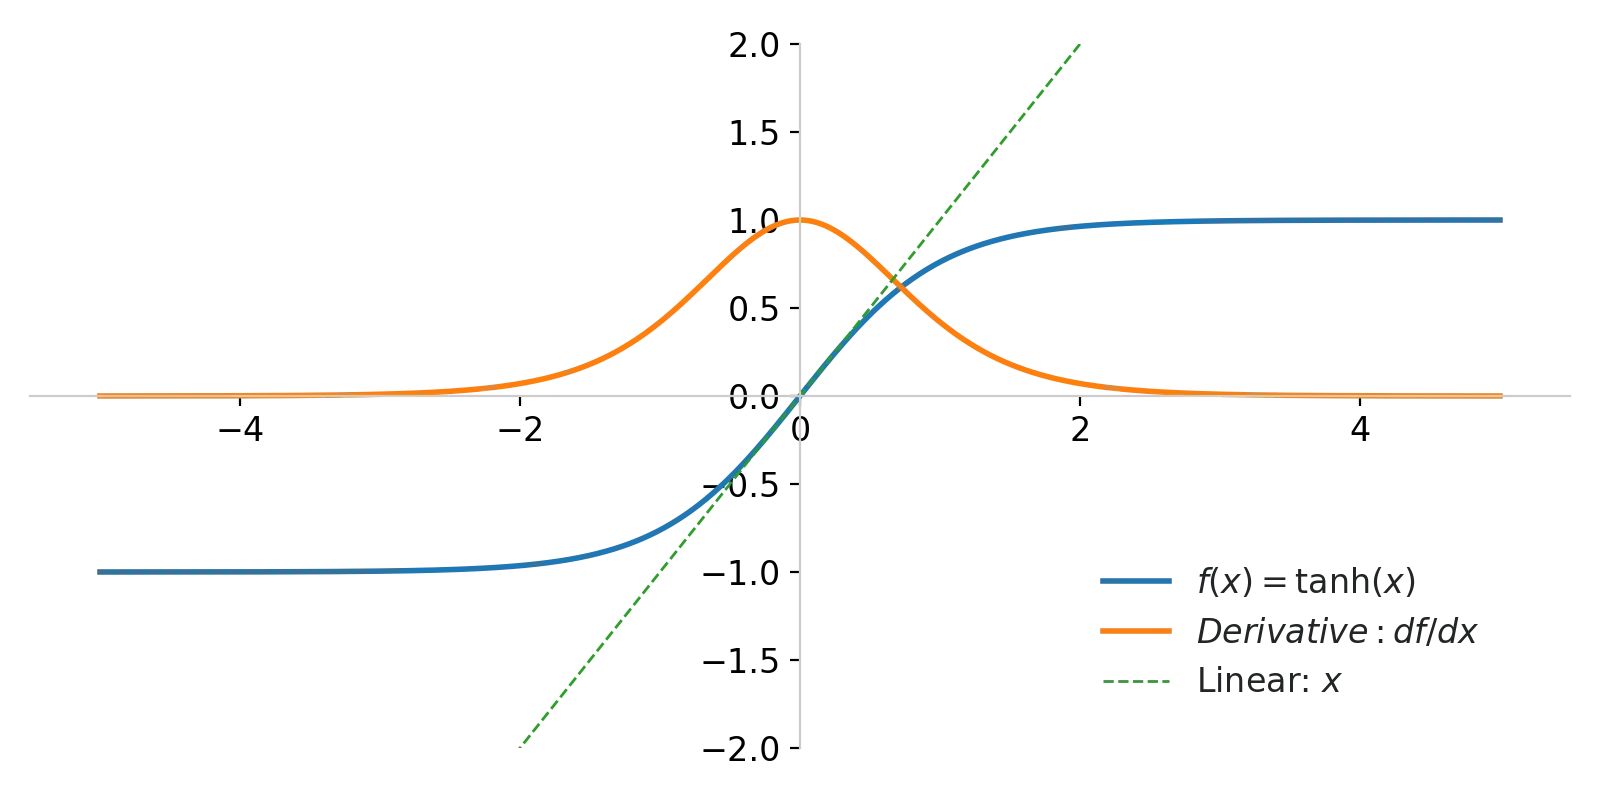
</div>

<figcaption align = "center">

Figure 1 "Shape" of $f(x)=\tanh(x)$ and its derivative $\dfrac{df}{dx}(x)=1-\tanh^2(x)$

</figcaption>

By expanding $v[k]$, the temporal evolution of $x[k]$ can be expressed as follows:

$$
\begin{align*}
x[k+1] = \tanh\left(\rho W^\mathrm{rec} x[k] + \sigma W^\mathrm{in} u[k+1] + \phi W^\mathrm{in}\right)
.\end{align*}
$$

We begin by focusing on the characteristics of $\sigma$, by fixing $\phi=0$.
As can be seen from the equation and the figure, the larger $\sigma$ is, the more the domain of $\tanh$ extends into its "flat" range.
Conversely, the smaller $\sigma$ is, the more $\tanh$ argument stays in its near-linear region, where $\tanh\approx x$.
Therefore, $\sigma$ has a significant impact on the nonlinearity of the ESN.

Next, let's examine the effect of $\phi$.
This will be explained in more detail in a later chapter on information processing capacity (IPC), but in short, $\phi$ influences the order of components included in the transformation.
Given that the input is symmetric (mean 0), if we polynomially expand $x[k]$ using $\{ u[k],~u[k-1].~\ldots\}$, only odd-order elements (such as $u^3[\cdot], u^5[\cdot], u[\cdot]u^2[\cdot]$) will appear in the case of $\phi=0$.
In contrast, the input will no longer have a zero mean when $\phi \neq 0$, and so even-order elements (such as $u^2[\cdot], u^4[\cdot]$) will appear as well.

Such distributions of components have a significant impact on task performance.
For example, analysis has shown that the NARMA10 task with the current setting of parameters is largely composed of the following components<sup>[1]</sup>:
- 1st-order: $u[k-1],~u[k-2],~u[k-3],~u[k-10],~u[k-11],~u[k-12]$
- 2nd-order: $u[k-1]u[k-10],~u[k-2]u[k-11],~u[k-3]u[k-12]$

Therefore, there is a significant performance difference between the cases of $\phi=0$ and $\phi\neq0$.
In the following exercise, let's verify the effects of $(\sigma, \phi)$ that we have discussed so far.

Q2.1.

Parameters $\Sigma = (\sigma_0$, $\sigma_1,~\ldots,~\sigma_{k-1})$ and $\Phi = (\phi_0$, $\phi_1,~\ldots,~\phi_{k-1})$ are given as arrays of length $k$.
Fill in the blanks in the following code to complete the function `convert_us_into_vs`, which outputs $v_i[k] = \sigma_i u[k] + \phi_i$ for each $(\sigma_i, \phi_i)$ at once.
Note that you should pay attention to the `shape` of the given input `us`, which is $U=\{u[0],~\ldots,~u[k-1]\} \in \mathbb{R}^{T \times 1}$.

- `convert_us_into_vs`
  - Argument(s):
    - `us`: `np.ndarray`
      - `shape`: `(t, 1)`
    - `sigma`: `np.ndarray`
      - `shape`: `(k,)`
    - `phi`: `np.ndarray`
      - `shape`: `(k,)`
  - Return(s):
    - `vs`: `np.ndarray`
      - `shape`: `(k, t, 1)`

In [ ]:
def convert_us_into_vs(us, sigma, phi):
    assert len(sigma) == len(phi)
    vs = ...  # TODO Use broadcasting to convert `us` into `vs`.
    return vs


test_func(convert_us_into_vs, "02_01")
# show_solution("02_01", "convert_us_into_vs")  # Uncomment it to see the solution.

Using the implemented `convert_us_into_vs`, let's compare the symmetric case ($v[k]\sim \mathcal{U}([-\sigma, \sigma])$) with the asymmetric case ($v[k]\sim \mathcal{U}([0, \sigma])$).
When $\sigma$ is small, the asymmetric case outperforms the symmetric case in terms of task accuracy.

In [ ]:
seed_setup, seed_dataset = 1234, 5678  # you can freely change here
dim, rho = 100, 0.9
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)

w_in, net, w_out = create_setup(seed_setup, dim, rho, f=np.tanh)
ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)


sigmas = np.logspace(-2, 0, 21)  # 10^{-2.0}, 10^{-1.9}, ... 10^{0.0}
x0 = np.zeros((sigmas.shape[0], net.dim))

# Symmetrical case (phi=0).
vs_sym = convert_us_into_vs(us, sigmas, np.zeros_like(sigmas))
nrmse_sym, _xs_sym = train_and_eval(x0, w_in, net, w_out, ts, vs_sym, ys, time_info)
best_sym = np.argmin(nrmse_sym[:, 0])

# Asymmetrical case (phi=sigma).
vs_asym = convert_us_into_vs(us, 0.5 * sigmas, 0.5 * sigmas)
nrmse_asym, _xs_asym = train_and_eval(x0, w_in, net, w_out, ts, vs_asym, ys, time_info)
best_asym = np.argmin(nrmse_asym[:, 0])

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(sigmas, nrmse_sym[:, 0], label=r"sym: $[-\sigma, \sigma]$")
ax.plot(sigmas, nrmse_asym[:, 0], label=r"asym: $[0, \sigma]$")
ax.scatter(sigmas[best_sym], nrmse_sym[best_sym, 0], s=100.0, marker="*")
ax.scatter(sigmas[best_asym], nrmse_asym[best_asym, 0], s=100.0, marker="*")
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"NRMSE (best: $\bigstar$)")
ax.legend(frameon=False)

None

Q2.2. (Advanced)

- Try the same experiment for other nonlinear activation functions. In particular, try an even activation function and observe the effect.
- The accuracy deteriorates quickly when $\sigma$ is large. Discuss why this happens, by comparing the time series of $x[k]$.

### 3. ESN parameters

Next, let's examine the role of the ESN's internal parameters $(N, \rho, a)$.

#### Number of ESN nodes

In general, the performance of RC improves as the **dimensionality** $N$ increases.
As will be discussed in the IPC chapter later, this is because the upper limit of IPC is determined by the dimensionality $N$ of the reservoir.
Therefore, the size of $N$ is a significant parameter that determines the performance of the reservoir.

Executing the next cell will plot the change in NRMSE according to the change in $N$.

In [ ]:
seed_setup, seed_dataset = 1234, 5678
dims = [10, 20, 50, 100, 200, 500, 1000]
rho = 0.9
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)

w_in, net, w_out = create_setup(seed_setup, dim, rho, f=np.tanh)
ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = 0.05 * us + 0.05  # vs \in [0.0, 0.1]

nrmses = []
for dim in tqdm(dims):
    x0 = np.zeros(dim)
    w_in, net, w_out = create_setup(seed_setup, dim, rho, f=np.tanh)
    nrmse = train_and_eval(x0, w_in, net, w_out, ts, vs, ys, time_info)
    nrmses.append(nrmse[0])
nrmses = np.asarray(nrmses)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(dims, nrmses, marker=".", markersize=10.0)
ax.set_xscale("log")
ax.set_xlabel("# of ESN nodes")
ax.set_ylabel("NRMSE")

None

More precisely, the upper limit of a reservoir's IPC is determined by its rank $r (\leq N)$.
This represents the number of linearly independent states and is usually calculated as the rank of $X$ (when we include the constant bias component) or its covariance matrix $C(X):=\mathrm{E}[(X-\mathrm{E}[X])^\top (X-\mathrm{E}[X])]$ (when we exclude the constant bias component).
For example, consider the following state matrix $X=[{x}_0; {x}_1; {x}_2]^{}\in\mathbb{R}^{T\times 3}$ with dimensionality $N=3$:

$$
\begin{align}
{x}_0 &= [u[0],~u[1],~\ldots,~u[T-1]]^\top, \\
{x}_1 &= [u^2[0],~u^2[1],~\ldots,~u^2[T-1]]^\top, \\
{x}_2 &= [3u^2[0]-4u[0],~3u^2[1]-4u[1],~\ldots,~3u^2[T-1]-4u[T-1]] ^\top
.\end{align}
$$

Since $x_2=3x_1 - 4x_0$, $x_2$ is linearly dependent and therefore the rank of $X$ is 2.

```py
In [*]: rnd = np.random.default_rng(1234)
   ...: us = rnd.uniform(-1, 1, (100, 1))
   ...: xs = np.concatenate([us, us**2, 3 * us**2 - 4 * us], axis=1)
   ...: xs_m = xs - xs.mean(axis=0)
   ...: print('rank: {}'.format(np.linalg.matrix_rank(xs_m.T @ xs_m)))
rank: 2
```

The output of linear regression, $\hat{Y}$, can be interpreted as the projection of $Y$ onto the subspace spanned by $X$, expressed as $\hat{Y}=P_X Y$ using the projection matrix $P_X=X X^+$.
The dimension of this subspace is determined by the rank $r$ of $X$.
In the $N=3$ example above, the linearly dependent component $x_2$ does not increase the dimension of the subspace and thus does not contribute to the reduction of the residual error $\|P_X Y - Y \|^2$.
In terms of IPC, $x_2$ is an extra component that does not contribute to an increase in IPC.
In this way, the rank $r$ is an indicator for quantitatively evaluating redundant components and appears frequently in the context of RC.

A case where the rank is not maximal can be easily constructed using a linear ESN with the identity map as the activation function.
The code below compares the rank of a linear ESN with that of a nonlinear ESN using $\tanh$ as its activation function.

In [ ]:
seed_setup, seed_dataset = 1234, 5678
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dims = np.arange(1, 11) * 10
rho = 0.9
dataset_info = dict(t_washout=100, t_train=2000, t_eval=0)

ts, us, _ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = sigma * us + phi

rank_nlin, rank_lin = [], []
for dim in tqdm(dims):
    x0 = np.zeros(dim)
    t_washout = dataset_info["t_washout"]
    w_in, net, _w_out = create_setup(seed_setup, dim, rho, f=np.tanh)
    # Non-linear case
    xs_nlin = sample_dynamics(x0, w_in, net, ts, vs)[t_washout:]
    xs_nlin -= xs_nlin.mean(axis=0)
    rank_nlin.append(np.linalg.matrix_rank(xs_nlin.T @ xs_nlin))
    # Linear case
    net.f = lambda val: val  # Identity function
    xs_lin = sample_dynamics(x0, w_in, net, ts, vs)[t_washout:]
    xs_lin -= xs_lin.mean(axis=0)
    rank_lin.append(np.linalg.matrix_rank(xs_lin.T @ xs_lin))
rank_nlin = np.asarray(rank_nlin)
rank_lin = np.asarray(rank_lin)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(dims, dims, color="k", label=r"$r=N$")
ax.plot(dims, rank_nlin, marker=".", markersize=10.0, color="red", ls=":", label=r"$f=\tanh$")
ax.plot(
    dims,
    rank_lin,
    marker=".",
    markersize=10.0,
    color="blue",
    ls="--",
    label=r"$f=\mathrm{id}_\mathbb{R}$",
)
ax.set_xlabel("# of ESN nodes")
ax.set_ylabel(r"rank $r$")
ax.legend(frameon=False)

None

Q3.1. (Advanced)

- In the linear case, the rank does not become maximal when $N$ is large, as shown in the above example. To understand this cause intuitively, plot the absolute values $|\lambda_{i}|$ of the eigenvalues $\{\lambda_i \}_{i=0}^{N-1}$ of the covariance matrix $C(X)$ in ascending order on a logarithmic graph. Compare this between the linear and nonlinear ESNs.
- Based on the distribution of the absolute values of the eigenvalues, devise a method of initializing $W^\mathrm{rec}$ that maximizes the rank even in a linear ESN.

#### Spectral radius

Next, we will examine the effect of the spectral radius $\rho$.
As introduced in the previous chapter, the spectral radius $\rho$ is defined as the maximum absolute value among the eigenvalues $\{\lambda_i \}_{i=0}^{N-1}$ of $W^\mathrm{rec}$ using the following formula:

$$
\begin{align*}
\rho(W^\mathrm{rec}):=\max_{i} |\lambda_{i}|
.\end{align*}
$$

You can visually understand why it is called the spectral "radius" by arranging the eigenvalues on a complex plane.
Especially when each element of $W^\mathrm{rec} \in \mathbb{R}^{N\times N}$ is sampled from the normal distribution $\mathcal{N}\left(0, \frac{1}{N}\right)$, the eigenvalues are approximately uniformly distributed on a unit disk of radius 1 (more precisely, as $N\to \infty$, they almost surely converge to a uniform distribution on the unit disk, a phenomenon known as the [*circular law*](https://en.wikipedia.org/wiki/Circular_law) in random matrix theory).

In the class `ESN`, the spectral radius $\rho$ can be separated and treated as a hyperparameter by setting the option `normalize = True`.
To begin with, let's implement the function `reshape_rho` that allows the simultaneous sampling of $x[t]$ for multiple values of $\rho$.

Q3.2.

An array of spectral radii $\Rho = \left(\rho_0, \rho_1,~\ldots,~\rho_{k-1} \right)$ with length $k$ is given.
Fill in the blanks in the following code to complete `reshape_rho`, which enables the simultaneous sampling of $x_{i}[k]$ when only the spectral radius $\rho_i$ is changed for the same input $u[k]$ and $W^\mathrm{rec}$.

- `reshape_rho`
  - Argument(s):
    - `rho`: `np.ndarray`
      - `shape`: `(k,)`
  - Return(s):
    - `rho_new`: `np.ndarray`
      - `shape`: `(k, 1)`

In [ ]:
def reshape_rho(rho):
    rho_new = ...  # TODO
    return rho_new


test_func(reshape_rho, "03_02")
# show_solution("03_02", "reshape_rho")  # Uncomment it to see the solution.

To intuitively understand the effect of the spectral radius $\rho$, let's consider the case of a linear ESN with no input (i.e., $u[k]=0, f=\mathrm{id}_\mathbb{R}$).
In this case, the temporal evolution of the ESN can be represented by the following equation:

$$
\begin{align*}
x[t+1] = \rho W^\mathrm{rec} x[t]
,\end{align*}
$$

where the analytical solution for $x[k]$ is given as follows:

$$
\begin{align*}
x[k] = \rho^k \left({W^\mathrm{rec}}\right)^k x[0]
.\end{align*}
$$

Because $W^\mathrm{rec}$ is normalized, $\left({W^\mathrm{rec}}\right)^k$ itself does not diverge.
However, $\rho^k$ diverges to infinity when $\rho > 1$ and converges when $\rho < 1$.
The following cell visualizes the response of $x[k]$ according to differences in $\rho$.
For comparison, the case of nonlinear ESN with $\tanh$ is shown on the right side.

In [ ]:
seed_setup, seed_dataset = 1234, 5678
dim, rhos = 50, np.array([0.99, 1.0, 1.01])
dataset_info = dict(t_washout=300, t_train=0, t_eval=0)

w_in, net, _w_out = create_setup(seed_setup, dim, reshape_rho(rhos))  # Use `reshape_rho`.
ts, us, _ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = np.zeros_like(us)  # Zero input
x0 = net.rnd.uniform(low=-0.5, high=0.5, size=(1, dim))
x0 = np.broadcast_to(x0, (len(rhos), dim))  # Using the same initial conditions

xs_nlin = sample_dynamics(x0, w_in, net, ts, vs)
net.f = lambda val: val  # Identity function
xs_lin = sample_dynamics(x0, w_in, net, ts, vs)

fig, ax = plt.subplots(len(rhos), 2, figsize=(12, 10), gridspec_kw=dict(hspace=0.05, wspace=0.2))
for idx, rho in enumerate(rhos):
    ax[idx, 0].set_ylabel(r"$\rho = {:.2f}$".format(rho))
    for idy, xs in enumerate([xs_lin, xs_nlin]):
        ax[idx, idy].plot(xs[idx], lw=1.0)
        ax[idx, idy].axhline(1.0, ls="--", color="k", lw=1.0)
        ax[idx, idy].axhline(-1.0, ls="--", color="k", lw=1.0)
        ax[idx, idy].set_yticks([-1.0, 1.0])
        if idx < len(rhos) - 1:
            ax[idx, idy].set_xticklabels([])
ax[-1, 0].set_xlabel("time steps")
ax[-1, 1].set_xlabel("time steps")
ax[0, 0].set_title(r"$f=\mathrm{id}_\mathbb{R}$")
ax[0, 1].set_title(r"$f=\tanh$")

None

First, despite having the same initial value $x[0]$, the range of $x[k]$ for $\rho = 1.01$ deviates significantly from $[-1, 1]$.
In the case of a nonlinear ESN, $x[k]$ remains within the range $[-1, 1]$ even when $\rho \geq 1$ because the $\tanh$ function prevents it from diverging to infinity.
However, it does not converge to zero as it does when $\rho < 1$.
Here, the ESP does not hold, and the influence of $x[0]$ continues to persist.
As will be discussed in later sections, increasing $\rho$ can lead to *chaos*, a phenomenon characterized by aperiodicity and sensitivity to initial conditions.

Therefore, for typical use cases such as NARMA10, the parameter search for $\rho$ is often restricted to $\rho < 1$.
Now, let's return to considering the case with input.
For simplicity, consider a linear ESN with input scaling $(\sigma, \phi)=(1, 0)$ and other settings $(f, W^\mathrm{rec})=(\mathrm{id}_\mathrm{R}, I)$.
In this case, the temporal evolution of the state is expressed by the following equation:

$$
\begin{align*}
x[k+1] = \rho x[k] + W^\mathrm{in} u[k+1]
,\end{align*}
$$

where the analytical solution for $x[k]$ can be expressed as follows:

$$
\begin{align*}
x[k] = W^\mathrm{in} \sum_{j=0}^\infty \rho^{j}  u[k-j]
.\end{align*}
$$

As inferred from the equation, $\rho$ is a parameter that controls how long the reservoir holds internal states $x[k]$.
The closer $\rho$ is to 1, the more it retains past inputs.
To check this effect, let's now investigate the dependency of NARMA10 accuracy on $\rho$.
The following code plots the NRMSE of the NARMA10 task and the rank of $x[k]$ as $\rho$ changes from 0 to 1 in increments of 0.02.

In [ ]:
seed_setup, seed_dataset = 1234, 5678
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dims = [25, 50, 100]
rhos = np.linspace(0.0, 1.0, 51)[1:-1]  # 0.02, ..., 0.98
rhos_batch = reshape_rho(rhos)  # use `reshape_rhos`.
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = sigma * us + phi

nrmses, best_ids, ranks = [], [], []
for dim in tqdm(dims):
    w_in, net, w_out = create_setup(seed_setup, dim, rhos_batch, f=np.tanh)
    x0 = np.zeros((rhos.shape[0], net.dim))
    nrmse, xs = train_and_eval(x0, w_in, net, w_out, ts, vs, ys, time_info)
    nrmses.append(nrmse[:, 0])
    best_ids.append(np.argmin(nrmse[:, 0]))
    xs_m = xs - xs.mean(axis=-2, keepdims=True)
    ranks.append(np.linalg.matrix_rank(xs_m.swapaxes(-2, -1) @ xs_m))

fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw=dict(hspace=0.05))
for dim, nrmse, best_id, rank in zip(dims, nrmses, best_ids, ranks, strict=False):
    ax[0].plot(rhos, rank / dim, label=r"$N={}$".format(dim))
    ax[1].plot(rhos, nrmse, label=r"$N={}$".format(dim))
    ax[1].scatter(rhos[best_id], nrmse[best_id], s=100.0, marker="*")
ax[0].set_xticklabels([])
ax[0].set_ylabel(r"$r/N$")
ax[1].set_xlabel(r"$\rho$")
ax[1].set_ylabel(r"NRMSE (best: $\bigstar$)")
ax[1].legend(frameon=False)

None

Because NARMA10 requires past input components with order of about 10, the optimal range of $\rho$ is where it is relatively close to 1, allowing the reservoir to keep past inputs for a longer period.

#### Leaky rate

Another important parameter in ESNs is $a$, a parameter that controls the extent to which past states are retained (similar to the spectral radius).
It takes values in the range $[0, 1]$.
In particular, the case of $a=1$ is equivalent to a discrete ESN without the linear term, and the case of $a=0$ is equivalent to a constant $x[k]=\mathrm{const.}$

The leaky rate $a$ often appears in the context of continuous ESNs defined in continuous time and their approximations, as shown below:

$$
\begin{align*}
\tau \dfrac{dx}{dt}(t) = -x(t) + \tanh\left(\rho W^\mathrm{rec} x(t) + W^\mathrm{in} v(t)\right)
,\end{align*}
$$

where $\tau \in \mathbb{R}$ is a time constant.
By approximating this equation using the Euler method, it can now be expressed as the following discrete equation.

$$
\begin{align*}
x(t+\Delta t) = \left(1-\dfrac{\Delta t}{\tau}\right) x(t) + \dfrac{\Delta t}{\tau}\tanh\left(\rho W^\mathrm{rec} x(t) + W^\mathrm{in} v(t + \Delta t)\right)
.\end{align*}
$$

With $t := k \Delta t, a=\Delta t / \tau$, this equation becomes equivalent to the original equation.
In the context of continuous ESNs, $a=0.1$ is commonly seen, but is not necessarily limited to this value.
Similar to $\rho$, let's implement the function `reshape_lr` that allows the simultaneous sampling of $x[k]$ for multiple values of $a$.

Q3.3.

An array of leaky rates $A = \left(a_0, a_1,~\ldots,~a_{k-1} \right) $ with length $k$ is given.
Fill in the blanks in the following code to complete `reshape_lr`, which enables the simultaneous sampling of $x_{i}[k]$ when only the leaky rate $a_{i}$ is changed for the same input $u[k]$ and $W^\mathrm{rec}$.

- `reshape_lr`
  - Argument(s):
    - `lr`: `np.ndarray`
      - `shape`: `(k,)`
  - Return(s):
    - `lr_new`: `np.ndarray`
      - `shape`: `(k, 1)`

In [ ]:
def reshape_lr(lr):
    lr_new = ...  # TODO
    return lr_new


test_func(reshape_lr, "03_03")
# show_solution("03_03", "reshape_lr")  # Uncomment it to see the solution.

The next code plots the NRMSE of NARMA10 tasks when $a$ is changed from $10^{-2}$ to $1$ (discrete ESN).
Note that the spectral radius is set to $\rho=0.5$, to reduce the contribution of internal connections on the reservoir's memory.

In [ ]:
seed_setup, seed_dataset = 1234, 5678
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dims = [25, 50, 100]
rho = 0.5
leaky_rates = np.logspace(-1, 0, 21)
lr_batch = reshape_lr(leaky_rates)  # Use `reshape_lr`.
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = sigma * us + phi

nrmses, best_ids = [], []
for dim in tqdm(dims):
    w_in, net, w_out = create_setup(seed_setup, dim, rho, f=np.tanh, a=lr_batch)
    x0 = np.zeros((leaky_rates.shape[0], net.dim))
    nrmse, xs = train_and_eval(x0, w_in, net, w_out, ts, vs, ys, time_info)
    nrmses.append(nrmse[:, 0])
    best_ids.append(np.argmin(nrmse[:, 0]))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for dim, nrmse, best_id in zip(dims, nrmses, best_ids, strict=False):
    ax.plot(leaky_rates, nrmse, label=r"$N={}$".format(dim))
    ax.scatter(leaky_rates[best_id], nrmse[best_id], s=100.0, marker="*")
ax.set_xlabel(r"$a$")
ax.set_xscale("log")
ax.set_ylabel(r"NRMSE (best: $\bigstar$)")
ax.legend(frameon=False)
ax.grid(True, which="minor")

None

Q3.4. (Advanced)

- Try experiments with tasks requiring shorter time constants (such as NARMA10), and observe how the dependency on $\rho$ and $a$ changes.
- Euler's method can be generalized as a [1st-order Runge-Kutta (RK) method](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods). Apply higher-order RK methods (e.g., RK4) to the differential equation of ESN in continuous time to implement a discretized ESN.

### 4. Dataset size

Let's check the effect of the dataset size $T_\textrm{train}$.
In general, more accurate evaluations become possible as the time series for training data gets longer.
The following code plots the NRMSE of NARMA10 tasks for different lengths of training data, $T_\textrm{train}= (100, 200, 400, 800, 1600, 3200)$.
Other parameters are set to $(\sigma, \phi, N, \rho) = (0.05, 0.05, 50, 0.9)$, and 100 samples of $(W^\mathrm{in}, W^\mathrm{rec})$ are generated randomly and evaluated by default.
It may take a few minutes to complete.
If it takes too long, try reducing the value of `sample_num` or `dim`.

In [ ]:
sample_num = 100
seed_setup, seed_dataset = 1234, 5678
t_trains = [100, 200, 400, 800, 1600, 3200]
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dim, rho = 50, 0.9
dataset_info = dict(t_washout=100, t_train=max(t_trains), t_eval=1000)

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
w_in_ws, net_ws = [], []
for seed in trange(sample_num):  # Create setups for `sample_num` times.
    w_in, net, _w_out = create_setup(seed_setup + seed, dim, rho, f=np.tanh)
    w_in_ws.append(w_in.weight)
    net_ws.append(net.weight)

w_in_batch = Linear(1, dim)
w_in_batch.weight = np.array(w_in_ws)[:, None, :, :]  # [*bs, 1, N, 1] ([1] -> [*bs, 1, N])
net_batch = ESN(dim, sr=rho)
net_batch.weight = np.array(net_ws)  # [bs, N, N] ([*bs, 1, N] -> [*bs, 1, N])
w_out = BatchLRReadout(dim, 1)

vs = sigma * us + phi
x0 = np.zeros((sample_num, 1, net.dim))
xs = sample_dynamics(x0, w_in_batch, net_batch, ts, vs, display=True)
nrmse_dict = {}
for t_train in t_trains:
    time_info["t_washout"] = dataset_info["t_washout"] + max(t_trains) - t_train
    nrmse = eval_nrmse(xs, ys, w_out, time_info=time_info)[:, 0, 0]
    nrmse_dict[t_train] = nrmse
    print("t_train={}: {:.3e}±{:.3e} (#sample={})".format(t_train, nrmse.mean(), nrmse.std(), nrmse.size))

nrmse_aves = [nrmse.mean() for nrmse in nrmse_dict.values()]
nrmse_stds = [nrmse.std() for nrmse in nrmse_dict.values()]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.errorbar(t_trains, nrmse_aves, nrmse_stds)
ax.set_xlabel(r"$T_\mathrm{train}$")
ax.set_xscale("log")
ax.set_ylabel("NRMSE")
ax.set_yscale("log")
ax.grid(True, which="both")

None

When $T_\mathrm{train}$ is too small, the performance is poor and unstable, with a large variance.
This suggests that the condition $N \geq T_\mathrm{train}$ for achieving the maximum rank is not sufficient, and that longer time samples are **also** needed.
In practice, it is desirable for $T_\mathrm{train}$ to be much larger than $N$.
Empirically, a length more than 10 times $N$ is often used.

Q4.1. (Advanced)

- Increase $N$, and investigate the relationship between $T_\mathrm{train}$ and the NRMSE in a similar way.
- Conduct similar investigations for other tasks.

### 5. Addressing short time series

> *"I remember my friend Johnny von Neumann used to say, with four parameters I can fit an elephant, and with five I can make him wiggle his trunk."*
> — [Enrico Fermi, 1953](https://en.wikipedia.org/wiki/Von_Neumann%27s_elephant)

In the previous section, we highlighted the importance of large $T_\mathrm{train}$.
However, in reality, it can be difficult to obtain training data with sufficient length relative to the reservoir dimensionality $N$.
This typically occurs in research on physical reservoirs, where the intrinsic time constants of physical systems or the sampling frequency of sensors limit the size of $T_\mathrm{train}$.
Conversely, it is also possible to encounter very high-dimensional settings where $N$ is so large that the required $T_\mathrm{train}$ becomes impractically large, making computation or data storage infeasible.

In such situations, it is crucial to avoid the phenomenon called **overfitting**.
This refers to the situation where the model fits the training data too closely, resulting in poor generalization performance on evaluation (validation) data.
Here, we introduce some techniques to avoid overfitting: **ridge regression** and the automatic adjustment of the ridge parameter using **Akaike information criteria (AIC)**.

#### Ridge regression

Ridge regression is a method that adds a regularization term to the cost function $\mathrm{RSS}(X, Y, w):=\|Xw - Y\|^2$ of the least squares problem, imposing a constraint on the size ($L^2$ norm) of the weight parameter $w$.
With the ridge parameter $\lambda(>0)$, the new cost function $\mathcal{L}^\mathrm{ridge}$ is defined by the following equation:

$$
\begin{align*}
\mathcal{L}^\mathrm{ridge}(X, Y, w, \lambda) & := \mathrm{RSS}(X, Y, w) + \lambda \|w\|^2
,\end{align*}
$$

where the optimal $\hat{w}^\mathrm{ridge}$ that minimizes this cost function can be obtained in one-shot (similar to linear regression) using the following equation:

$$
\begin{align*}
\hat{w}^\mathrm{ridge}(X, Y, \lambda):&=\mathrm{arg}\min_{w} \mathcal{L}^\mathrm{ridge}(X, Y, w, \lambda) \\
&=(X^\top X + \lambda I)^{-1}X^\top Y
.\end{align*}
$$

The Gram matrix $X^\top X$ is a positive semi-definite matrix (all eigenvalues are non-negative), so $X^\top X + \lambda I$ is a positive definite matrix and always has an inverse.
Therefore, ridge regression is numerically more stable than ordinary linear regression.

Q5.1.

Fill in the blanks of the following code to complete `RidgeReadout`, inheriting from `Linear`.
This class takes the predictor sequence $\tilde{X}=[1 : X]\in\mathbb{R}^{...\times T\times (N+1)}$ (with additional bias term), target sequence $Y\in \mathbb{R}^{... \times T \times D}$, and ridge parameter $\lambda \in \mathbb{R}^{+}$ as arguments.
It calculates $\hat{w}^\mathrm{ridge}\in\mathbb{R}^{...\times(N+1)\times D}$ that minimizes  $\mathcal{L}^\mathrm{ridge}(\tilde{X}, Y, w)$, and then updates its weights and biases.
Refer to the implementation of `BatchLRReadout` as well.

- `RidgeReadout.train`
  - Argument(s):
    - `x`: `np.ndarray`
      - `shape`: `(..., time_steps, input_dim)`
    - `y`: `np.ndarray`
      - `shape`: `(..., time_steps, output_dim)`
  - Returns(s):
    - `self.weight`: `np.ndarray`
      - `shape`: `(..., output_dim, input_dim)`
    - `self.bias`: `np.ndarray`
      - `shape`: `(..., 1, output_dim)`

  - Operation(s):
      - Update `self.weight` with the obtained weight.
      - Update `self.bias` with the obtained bias.

In [ ]:
class RidgeReadout(Linear):
    def __init__(self, *args, lmbd: float = 0.0, **kwargs):
        super(RidgeReadout, self).__init__(*args, **kwargs)
        self.lmbd = lmbd

    def train(self, x: np.ndarray, y: np.ndarray):
        assert (x.ndim > 1) and (x.shape[-1] == self.input_dim)
        assert (y.ndim > 1) and (y.shape[-1] == self.output_dim)
        x_biased = np.ones((*x.shape[:-1], x.shape[-1] + 1), dtype=self.dtype)
        x_biased[..., 1:] = x
        # TODO Implement ridge regression to obtain `self.weight` and `self.bias`.
        xtx = ...
        xty = ...
        sol = ...
        self.weight = ...
        self.bias = ...
        # end of TODO
        return self.weight, self.bias


def solution(dim_in, dim_out, x_train, y_train, x_eval, lmbd):
    # DO NOT CHANGE HERE.
    readout = RidgeReadout(dim_in, dim_out, lmbd=lmbd)
    readout.train(x_train, y_train)
    return readout(x_eval)


test_func(solution, "05_01")
# show_solution("05_01", "RidgeReadout")  # Uncomment it to see the solution.

The next cell includes the previous code that plots NRMSE for various values of $T_\mathrm{train}$, but here, `BatchLRReadout` is replaced with `RidgeReadout`.
Note that substituting $\lambda = 0$ makes the ridge regression equivalent to linear regression.

In [ ]:
sample_num = 100
seed_setup, seed_dataset = 1234, 5678
t_trains = [50, 100, 200, 400, 800, 1600, 3200]
ridge_parameters = [0.0, 1.0, 1e-2, 1e-4, 1e-6, 1e-8]
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dim, rho = 50, 0.9
dataset_info = dict(t_washout=100, t_train=max(t_trains), t_eval=1000)

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
w_in_ws, net_ws = [], []
for seed in trange(sample_num):  # Create setups for `sample_num` times.
    w_in, net, _w_out = create_setup(seed_setup + seed, dim, rho, f=np.tanh)
    w_in_ws.append(w_in.weight)
    net_ws.append(net.weight)

w_in_batch = Linear(1, dim)
w_in_batch.weight = np.array(w_in_ws)[:, None, :, :]  # [bs, 1, N, 1] (-> [bs, 1, N])
net_batch = ESN(dim, sr=rho)
net_batch.weight = np.array(net_ws)  # [bs, N, N] ([bs, 1, N] -> [bs, 1, N])
w_out = RidgeReadout(dim, 1)  # Use ridge regression.

vs = sigma * us + phi
x0 = np.zeros((sample_num, 1, net.dim))
xs = sample_dynamics(x0, w_in_batch, net_batch, ts, vs, display=True)
nrmse_dict = {lmbd: {} for lmbd in ridge_parameters}
for lmbd, t_train in tqdm(list(itertools.product(ridge_parameters, t_trains))):
    time_info["t_washout"] = dataset_info["t_washout"] + max(t_trains) - t_train
    w_out.lmbd = lmbd
    nrmse = eval_nrmse(xs, ys, w_out, time_info=time_info)[:, 0, 0]
    nrmse_dict[lmbd][t_train] = nrmse
    # print('λ={:.2e}, t_train={}: {:.3e}±{:.3e} (#sample={})'.format(
    #     lmbd, t_train, nrmse.mean(), nrmse.std(), nrmse.size))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for lmbd in ridge_parameters:
    nrmse_aves = [nrmse.mean() for nrmse in nrmse_dict[lmbd].values()]
    nrmse_stds = [nrmse.std() for nrmse in nrmse_dict[lmbd].values()]
    if lmbd == 0.0:
        plot_kws = dict(label=r"LR ($\lambda=0$)", color="k", ls=":")
    else:
        plot_kws = dict(label=r"Ridge ($\lambda=10^{{{:.0f}}}$)".format(np.log10(lmbd)))
    ax.errorbar(t_trains, nrmse_aves, nrmse_stds, **plot_kws)
ax.set_xlabel(r"$T_\mathrm{train}$")
ax.set_ylabel("NRMSE")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", borderaxespad=0, ncol=1, frameon=False)
ax.grid(True, which="both")

None

Linear regression becomes unstable around $T_\mathrm{train} \approx N$, but the accuracy of ridge regression ($\lambda=10^{-4}, 10^{-6}$) remains stable.
Furthermore, even when $T_\mathrm{train} \gg N$, ridge regression achieves almost the same accuracy and stability as linear regression.
On the other hand, when $\lambda$ is large ($\lambda=10^{0}, 10^{-2}$), the accuracy remains stable but is significantly worse than linear regression.
This phenomenon is called **underfitting**, the opposite of overfitting.
Additionally, choosing values of $\lambda$ that are too small ($\lambda=10^{-8}$) causes instability to occur around $T_\mathrm{train} \approx N$, i.e., overfitting, similar to linear regression.

Thus, the appropriate selection of the ridge parameter $\lambda$ is very important for learning accuracy and stability.

#### Automatic adjustment of ridge parameter $\lambda$ based on AIC

In ridge regression, introduction of the ridge parameter allows for more stable learning even in cases where $T_\mathrm{train}$ is small.
However, this ridge parameter $\lambda$ is a hyperparameter and requires separate tuning.
Specifically, since $\lambda$ can take any positive real number, its search range is infinite, making its tuning quite troublesome.
As a solution, we introduce an AIC to automatically determine $\lambda$.
AIC is a measure that balances model size and residual error, and is widely used in the field of machine learning to construct reasonable models.
In the case of ridge regression, AIC can be calculated using the following equation:

$$
\begin{align*}
\mathrm{AIC}(X, Y, \lambda) :&= T \ln\left(\mathrm{RSS}(X, Y, \hat{w}^\mathrm{ridge}(X, Y, \lambda))\right) + \mathrm{df}(X, \lambda) \\
&= T\ln\left(\|X\hat{w}^\mathrm{ridge}(X, Y, \lambda) - Y\|^2\right) + \mathrm{df}(X, \lambda)
,\end{align*}
$$

where $\mathrm{df}(X, \lambda)$ is the effective degrees of freedom of the model, given by

$$
\begin{align*}
\mathrm{df}(X, \lambda) :&= \mathrm{tr}[X(X^\top X + \lambda I)^{-1}X^\top] \\
&= \sum_{i=0}^{N-1}\frac{\sigma_{i}^2}{\sigma_{i}^2+\lambda}
.\end{align*}
$$

$\{\sigma_i \}_{i=0}^{N-1}$ are the singular values when singular value decomposition is applied to $X \in \mathbb{R}^{T\times N}$.
By minimizing AIC, an appropriate $\lambda$ can be obtained.
Also, $0<\mathrm{df} \leq N$ can be inferred from the equation.

Therefore, instead of directly searching for $\lambda$, we can prepare a set of candidate degrees of freedom $\{\mathrm{df}_k \}$, calculate $\lambda_k$ such that $\mathrm{df}_k = \mathrm{df}(X, \lambda_k)$ for each candidate of $\mathrm{df}$, and select $\lambda_k$ that minimizes $\mathrm{AIC}(X, Y, \lambda_k)$.
This approach allows us to search within a limited range of $\mathrm{df}$ candidates, instead of within the whole infinite range of $\lambda$.

Below, we write out the detailed algorithm:

1. Create a list of candidates for $\{\mathrm{df}_k\}$. Typically, only integer values $\{1,~\ldots,~N\}$ are selected as candidates.
2. Use Newton's method to solve for $\lambda_k$ such that $f(\lambda_k)=0$.
3. Compute  $\mathrm{AIC}(X, Y, \lambda_k)$ using $\lambda_k$.
4. Find the $k$ and $\lambda_k$ that minimizes $\mathrm{AIC}(X, Y, \lambda_k)$.

Here, the function $f(\lambda_k)$ is defined as

$$
\begin{align*}
f(\lambda_k) = \mathrm{df}_k - \sum_{i=0}^{N-1}\frac{\sigma_{i}^2}{\sigma_{i}^2+\lambda_k}
.\end{align*}
$$

Also, the derivative $\dfrac{df}{d\lambda_k}$ used in Newton's method is given by

$$
\begin{align*}
\dfrac{df}{d\lambda_k}(\lambda_k) = \sum_{i=0}^{N-1}\frac{\sigma_{i}^2}{\left(\sigma_{i}^2+\lambda_k\right)^2}
.\end{align*}
$$

Q5.2.

Fill in the blanks of the following code to complete `calc_df_and_lambda`, `calc_aic`, and `AutoRidgeReadout`, implementing the algorithm described above.

- `AutoRidgeReadout.train`
  - Argument(s):
    - `x`: `np.ndarray`
      - `shape`: `(..., time_steps, input_dim)`
    - `y`: `np.ndarray`
      - `shape`: `(..., time_steps, output_dim)`
  - Return(s):
    - `self.weight`: `np.ndarray`
      - `shape`: `(..., output_dim, input_dim)`
    - `self.bias`: `np.ndarray`
      - `shape`: `(..., 1, output_dim)`
    - `*misc`

  - Operation(s):
      - Update `self.weight` with the obtained weight.
      - Update `self.bias` with the obtained bias.
      - Update `self.lmbd` with the obtained $\lambda$ minimizing $\mathrm{AIC}$.

<details><summary>tips</summary>

- [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html)

</details>

In [ ]:
def calc_df_and_lambda(xs: np.array, df_max: int = None, num_cand: int = None, lmbd0=1e-12):
    batch_size, dim = xs.shape[:-2], xs.shape[-1]
    if df_max is None:
        df_max = dim
    if num_cand is None:
        num_cand = df_max

    _left, sigma, _right = np.linalg.svd(xs)
    sigma2 = (sigma**2)[..., None, :]  # [*bs, 1, dim]
    dfs = np.linspace(0, df_max, num_cand + 1)[1:]  # Candidates for degrees of freedom -> [num_cand]
    init_cond = np.full((*batch_size, num_cand), lmbd0)  # Initial condition for λ -> [*bs, num_cand]

    def func(lmbd):
        # TODO `lmbd`: [*bs, num_cand], `sigma2`: [*bs, 1, dim]
        ...

    def fprime(lmbd):
        # TODO `lmbd`: [*bs, num_cand], `sigma2`: [*bs, 1, dim]
        ...

    # TODO Solve f(λ) = 0 for using Newton's method. The output `lmbds` should be of shape [*bs, num_cand].
    lmbds = ...
    # end of TODO
    lmbds[lmbds < 0] = 0  # Remove negative λ due to numerical errors.
    return dfs, lmbds


def calc_aic(xs, ys, **kwargs):
    assert xs.shape[-2] == ys.shape[-2]
    *batch_size, length, dim_in = xs.shape
    dfs, lmbds = calc_df_and_lambda(xs, **kwargs)  # dfs: [num_cand], lmbds: [*bs, num_cand]
    xs = xs[..., None, :, :]  # [*bs, 1, length, dim_in]
    ys = ys[..., None, :, :]  # [*bs, 1, length, dim_in]
    xtx = xs.swapaxes(-2, -1) @ xs  # X^T X: [*bs, 1, dim_in, dim_in]
    xty = xs.swapaxes(-2, -1) @ ys  # X^T Y: [*bs, 1, dim_in, dim_out]
    # TODO Ridge regression with λ -> [*bs, num_cand, dim_in, dim_out]
    sol = ...
    # end of TODO
    rss = ...  # TODO RSS: [*bs, num_cand]
    aics = ...  # TODO AIC: [*bs, num_cand]
    return dfs, lmbds, sol, rss, aics


class AutoRidgeReadout(Linear):
    def __init__(self, *args, lmbd: float = 0.0, **kwargs):
        super(AutoRidgeReadout, self).__init__(*args, **kwargs)
        self.lmbd = lmbd

    def train(self, x: np.ndarray, y: np.ndarray, **kwargs):
        assert (x.ndim > 1) and (x.shape[-1] == self.input_dim)
        assert (y.ndim > 1) and (y.shape[-1] == self.output_dim)
        x_biased = np.ones((*x.shape[:-1], x.shape[-1] + 1), dtype=self.dtype)
        x_biased[..., 1:] = x
        dfs, lmbds, sol, rss, aics = calc_aic(x_biased, y, **kwargs)
        # dfs: [num_cand], lmbds: [*bs, num_cand]
        # sol: [*bs, num_cand, dim_in, dim_out]
        # rss: [*bs, num_cand], aics: [*bs, num_cand]
        best_idx = ...  # TODO Extract the index of the best solution minimizing AIC.
        sol_best = ...  # TODO Choose the best solution minimizing AIC.
        self.lmbd = ...  # TODO Save the best λ minimizing AIC.
        self.weight = ...  # TODO Update weight based on `sol_best`.
        self.bias = ...  # TODO Update bias based on `sol_best`.
        return self.weight, self.bias, dfs, lmbds, sol, rss, aics


def solution(dim_in, dim_out, x_train, y_train, x_eval):
    # DO NOT CHANGE HERE.
    readout = AutoRidgeReadout(dim_in, dim_out)
    readout.train(x_train, y_train)
    return readout(x_eval)


test_func(solution, "05_02")
# show_solution("05_02", "calc_df_and_lambda")  # Uncomment it to see the solution.
# show_solution("05_02", "calc_aic")  # Uncomment it to see the solution.
# show_solution("05_02", "AutoRidgeReadout")  # Uncomment it to see the solution.

Let's examine the effectiveness of `AutoRidgeReadout` with the case of $(\sigma,\phi,N,\rho,T_\mathrm{train})=(0.05,0.05,500,0.9,2000)$.
To reduce computation time, we set `num_cand = dim // 10` and $\{\mathrm{df}_k\}=\{10, 20,~\ldots,~500\}$.

In [ ]:
seed_setup, seed_dataset = 1234, 5678  # Please choose your favorite seeds.
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dim, rho = 500, 0.9
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = sigma * us + phi

w_in, net, w_out = create_setup(seed_setup, dim, rho, f=np.tanh, cls=AutoRidgeReadout)

x0 = np.zeros(net.dim)
xs = sample_dynamics(x0, w_in, net, ts, vs, display=True)
nrmse, _weight, _bias, dfs, lmbds, sol, rss, aics = eval_nrmse(
    xs, ys, w_out, time_info, return_out=True, df_max=dim, num_cand=dim // 10
)

best_idx = np.argmin(aics)
rel_aics = aics - aics.min() + 1e0  # Normalize AICs for better visualization.
y_out = w_out(xs)

plot_length = 200
fig = Figure(figsize=(8, 8))
fig.create_grid(2, 1, height_ratios=(2, 1), hspace=0.4)
ax0, ax1 = fig[0], fig[1]
ax0.create_grid(2, 1, wspace=0.4)
ax0[0].plot(dfs, lmbds)
ax0[0].scatter(dfs[best_idx], lmbds[best_idx], s=100.0, marker="*")
ax0[0].set_yscale("log")
ax0[0].set_ylabel(r"$\lambda$")
ax0[0].set_xticklabels([])
ax0[1].plot(dfs, rel_aics)
ax0[1].scatter(dfs[best_idx], rel_aics[best_idx], s=100.0, marker="*")
ax0[1].set_ylabel(r"relative $\mathrm{AIC}$")
ax0[1].set_yscale("log")
info_str = r"best: $\mathrm{{df}}={:.0f},~\lambda=10^{{{:.2f}}}$".format(dfs[best_idx], np.log10(lmbds[best_idx]))
ax0.set_title(info_str)
ax0[1].set_xlabel("df")

ax1.set_xlabel(r"$\mathrm{{df}}$")
ax1.plot(ts[-plot_length:], ys[-plot_length:], color="k", ls=":", lw=1.5)
ax1.plot(ts[-plot_length:], y_out[-plot_length:], lw=1.5, color="red")
ax1.set_title("NRMSE={:.3e}".format(nrmse[0]))
ax1.set_ylabel(r"$y[k]$ & $\hat{y}[k]$")
ax1.set_xlabel("time steps")

None

Try comparing the results of `AutoRidgeReadout` with linear regression ( $\lambda=0$ ) and the underfitting case ( $\lambda=10^{-2}$ ).

In [ ]:
sample_num = 20
seed_setup, seed_dataset = 1234, 5678
t_trains = [100, 200, 400, 800, 1600, 3200]
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dim, rho = 50, 0.9
dataset_info = dict(t_washout=100, t_train=max(t_trains), t_eval=1000)
ridge_parameters = [0.0, 1e-2, None]  # None: `AutoRidgeReadout`

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
w_in_ws, net_ws = [], []
for seed in trange(sample_num):  # Create setups for `sample_num` times.
    w_in, net, _w_out = create_setup(seed_setup + seed, dim, rho, f=np.tanh)
    w_in_ws.append(w_in.weight)
    net_ws.append(net.weight)

w_in_batch = Linear(1, dim)
w_in_batch.weight = np.array(w_in_ws)[:, None, :, :]  # [bs, 1, N, 1] (-> [bs, 1, N])
net_batch = ESN(dim, sr=rho)
net_batch.weight = np.array(net_ws)  # [bs, N, N] ([bs, 1, N] -> [bs, 1, N])
x0 = np.zeros((sample_num, 1, net.dim))
vs = sigma * us + phi
xs = sample_dynamics(x0, w_in_batch, net_batch, ts, vs, display=True)

nrmse_dict = {lmbd: {} for lmbd in ridge_parameters}
lbmd_dict = {lmbd: {} for lmbd in ridge_parameters}
for lmbd, t_train in tqdm(list(itertools.product(ridge_parameters, t_trains))):
    time_info["t_washout"] = dataset_info["t_washout"] + max(t_trains) - t_train
    if lmbd is None:
        w_out = AutoRidgeReadout(dim, 1)
        train_kws = dict(df_max=dim)
    else:
        w_out = RidgeReadout(dim, 1, lmbd=np.array(lmbd))
        train_kws = {}
    nrmse = eval_nrmse(xs, ys, w_out, time_info=time_info, **train_kws)
    nrmse_dict[lmbd][t_train] = np.array(nrmse)
    lbmd_dict[lmbd][t_train] = np.array(w_out.lmbd)
    # print('t_train={}: λ: {:.3e}±{:.3e}, NRMSE: {:.3e}±{:.3e}'.format(
    #     t_train, w_out.lmbd.mean(), w_out.lmbd.std(), nrmse.mean(), nrmse.std()))

fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw=dict(height_ratios=(1, 2), hspace=0.05))
for lmbd in ridge_parameters:
    nrmse_aves = [nrmse.mean() for nrmse in nrmse_dict[lmbd].values()]
    nrmse_stds = [nrmse.std() for nrmse in nrmse_dict[lmbd].values()]
    lmbd_aves = [lmbd.mean() for lmbd in lbmd_dict[lmbd].values()]
    lmbd_stds = [lmbd.std() for lmbd in lbmd_dict[lmbd].values()]
    if lmbd is None:
        plot_kws = dict(label=r"AutoRidge", color="red", ls="--", lw=2.0)
        ax[0].errorbar(t_trains, lmbd_aves, lmbd_stds, **plot_kws)
    elif lmbd == 0.0:
        plot_kws = dict(label=r"LR ($\lambda=0$)", color="k", ls=":")
    else:
        plot_kws = dict(label=r"Ridge ($\lambda=10^{{{:.0f}}}$)".format(np.log10(lmbd)))
    ax[1].errorbar(t_trains, nrmse_aves, nrmse_stds, **plot_kws)
ax[0].set_xscale("log")
ax[0].set_xticklabels([])
ax[0].set_ylabel(r"$\lambda$")
ax[0].grid(True, which="both")
ax[1].set_xlabel(r"$T_\mathrm{train}$")
ax[1].set_ylabel("NRMSE")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].legend(loc="upper right", borderaxespad=0, ncol=1, frameon=False)
ax[1].grid(True, which="both")

None

Q5.3. (Advanced)

- Test the robustness of `AutoRidgeReadout`, by changing values of $\sigma$ or $\rho$.
- Validate the performance for various values of $\lambda$ using `RidgeReadout`, and compare it with the performance of `AutoRidgeReadout`.
- `AutoRidgeReadout` does not necessarily choose $\lambda$ that minimizes the cost (NRMSE). Explain why.
- There exist other information criteria, such as the Bayesian Information Criterion (BIC). Implement models that minimize these other critieria, and compare their performance with that of AIC.

### 6. Grid search

Let's learn the method of **grid search**, which explores multiple parameters simultaneously to find the best combination.
In grid search, **all** combinations of hyperparameter candidate values are exhaustively searched.
For example, let's suppose we want to find the best combination of three parameters $(\sigma,\phi,\rho)$: input scale, bias, and spectral radius.
The following parameter values are set as candidates:

- $\sigma$ : $(0.05,0.10,0.15,~\ldots~,1.00)$
- $\phi$ : $(0.00,0.05,0.10,~\ldots~,1.00)$
- $\rho$ : $(0.6,0.7,0.8,0.9)$

In this case, there are $20\times 21\times 4=840$ total combinations, and all combinations are validated exhaustively in grid search.
Here, the previously introduced batch processing is very effective.
In the exercise below, let's learn how to specify the input $u[k]$ and the initial values of the ESN to conduct grid search efficiently.

Q6.1.

The following arguments are given: input sequence $U=\{u[k]\} \in \mathbb{R}^{T\times 1}$, an array of length $k$ containing input scaling $\Sigma = (\sigma_0$, $\sigma_1,~\ldots,~\sigma_{k-1})$, an array of length $l$ containing biases $\Phi = (\phi_0$, $\phi_1,~\ldots,~\phi_{l-1})$, an array of length $m$ containing spectral radii $\Rho = (\rho_0$, $\rho_1,~\ldots,~\rho_{m-1})$.
Fill in the blanks in the following code to complete `create_grid_search_setup`, a function that generates $v[k]$ and reshapes $\Rho$ to collectively sample all $k\times l\times m$ conditions as $x[k] \in \mathbb{R}^{k\times l\times m\times N}$, for the same weight intializations of $W^\mathrm{in}, W^\mathrm{rec}$ in each experiment.

- `create_grid_search_setup`
  - Argument(s):
    - `us`: `np.ndarray`
      - `shape`: `(t, 1)`
    - `sigma`: `np.ndarray`
      - `shape`: `(k,)`
    - `phi`: `np.ndarray`
      - `shape`: `(l,)`
    - `rho`: `np.ndarray`
      - `shape`: `(m,)`
  - Return(s):
    - `vs`: `np.ndarray`
      - `shape`: `(k, l, 1, t, 1)`
    - `rho_new`: `np.ndarray`
      - `shape`: `(m, 1)`

In [ ]:
def create_grid_search_setup(us, sigma, phi, rho):
    vs = ...  # TODO
    rho_new = ...  # TODO
    return vs, rho_new


test_func(create_grid_search_setup, "06_01", multiple_output=True)
# show_solution("06_01", "create_grid_search_setup")  # Uncomment it to see the solution.

The following code evaluates the NRMSE for all $840$ parameter combinations.
Depending on your environment, it may take around 2 to 3 minutes to complete the plot.
If it takes too long, consider reducing `dim` and `t_train`, or increasing the spacing between parameter values in `sigmas`, `phis`, and `rhos`.

In [ ]:
seed_setup, seed_dataset = 1234, 5678
dim = 50
sigmas = np.linspace(0.0, 1.0, 21)[1:]  # [0.05, 0.10, ...., 1.00]
phis = np.linspace(0.0, 1.0, 21)  # [0.0, 0.05,, ...., 1.00]
rhos = np.array([0.6, 0.7, 0.8, 0.9])

dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)
ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs_batch, rhos_batch = create_grid_search_setup(us, sigmas, phis, rhos)  # Use `create_grid_search_setup`.

w_in, net, w_out = create_setup(seed_setup, dim, rhos_batch, f=np.tanh)
x0 = np.zeros((sigmas.shape[0], phis.shape[0], rhos.shape[0], net.dim))
xs = sample_dynamics(x0, w_in, net, ts, vs_batch, display=True)
nrmse = eval_nrmse(xs, ys, w_out, time_info)[..., 0]  # [k, l, m]

top_num = 5
best_ids = np.array(np.unravel_index(np.argsort(nrmse, axis=None)[:top_num], nrmse.shape)).T
for idx, pos in enumerate(best_ids):
    print(
        "#{}: NRMSE={:.2e}, σ={:.2e}, Φ={:.2e}, ρ={:.2e}".format(
            idx + 1, nrmse[(*pos,)], sigmas[pos[0]], phis[pos[1]], rhos[pos[2]]
        )
    )

grid_num = (len(rhos) ** 0.5).__ceil__()
fig = Figure(figsize=(6 * grid_num, 5 * grid_num))
fig.create_grid(grid_num, grid_num, hspace=0.5, wspace=0.5)

vmax = min(1.0, np.max(nrmse))
vmin = max(0.1, np.min(nrmse))
for idx, rho in enumerate(rhos):
    fig[idx].plot_matrix(
        nrmse[..., idx],
        index=sigmas,
        column=phis,
        vmax=vmax,
        vmin=vmin,
        cmap="viridis",
        zscale="log",
        origin="lower",
    )
    fig[idx].set_xlabel(r"$\phi$")
    fig[idx].set_ylabel(r"$\sigma$")
    fig[idx].set_title(r"$\rho={:.2f}$".format(rho))

px, py, idx = best_ids[0]
fig[idx].scatter(py, px, s=200.0, marker="*", color="magenta")
fig.suptitle(
    r"best NRMSE={:.2e}, $(\sigma,\phi,\rho)=$({:g},{:g},{:g})".format(
        nrmse[(*best_ids[0],)], sigmas[px], phis[py], rhos[idx]
    )
)

None

Grid search requires computation proportional to the number of parameter combinations.
Therefore, as the number of hyperparameters increases, the calculations may become impractical or result in memory shortages.
A common strategy is to first set the parameters coarsely and then search more finely.

There are various methods, but the following algorithm is one simple example:
1. Decide the number of divisions $p$ for the parameters.
2. Specify the minimum value $\theta_\mathrm{min}$ and maximum value $\theta_\mathrm{max}$ of the parameter $\theta$ to be optimized.
3. Prepare $p$ parameter values to be searched, $\theta_{k} = \theta_\mathrm{min} + (k + 0.5)(\theta_\mathrm{max}-\theta_\mathrm{min})/p~(0 \leq k < p)$.
4. Calculate the objective function $\mathcal{L}(\theta_k)$ for each $\theta_k$.
5. Obtain $\hat{k}:=\mathrm{argmin}_k \mathcal{L}(\theta_k)$ that minimizes $\mathcal{L}(\theta_k)$.
6. Update $\theta_\mathrm{min}\leftarrow \theta_\mathrm{min}+\hat{k}(\theta_\mathrm{max}-\theta_\mathrm{min})/p$.
7. Update $\theta_\mathrm{max}\leftarrow \theta_\mathrm{min}+(\hat{k}+1)(\theta_\mathrm{max}-\theta_\mathrm{min})/p$.
8. Return to step 3.

This algorithm works only when the change of $\mathcal{L}$ is sufficiently smooth relative to the parameter division intervals.
However, it is simple to implement and useful for a rough search of good parameter combinations.
In the exercise below, let's implement the key parts of this algorithm.

Q6.2.

Real numbers $\theta_\mathrm{min}$ and $\theta_\mathrm{max}$, and a positive integer $p$ representing the number of parameter divisions are given.
Fill in the blanks in the following code to complete `create_parameter_set`, a function that generates an array $\{\theta_{k}\}$ of length $p$ containing candidate parameter values.

- `create_parameter_set`
  - Argument(s):
    - `th_min`: `float`
    - `th_max`: `float`
    - `num_split` : `int`
  - Return(s):
    - `th_new`: `np.ndarray`
      - `shape`: `(num_split,)`

In [ ]:
def create_parameter_set(th_min, th_max, num_split):
    th_new = ...  # TODO
    return th_new


test_func(create_parameter_set, "06_02")
# show_solution("06_02", "create_parameter_set")  # Uncomment it to see the solution.

The following code searches the parameter ranges with 5 divisions (`num_split`) over 10 iterations (`num_iteration`).

- $\sigma\in (0.0, 1.0)$
- $\phi\in (0.0, 1.0)$
- $\rho\in (0.0, 2.0)$

In [ ]:
num_split = 5
num_iteration = 10
seed_setup, seed_dataset = 1234, 5678
dim = 50
parameter_range = dict(
    sigma=(0.0, 1.0),
    phi=(0.0, 1.0),
    rho=(0.0, 2.0),
)
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)
ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)

for idx in range(num_iteration):
    # print(parameter_range)
    sigmas, phis, rhos = map(lambda v: create_parameter_set(*v, num_split), parameter_range.values())
    # print(sigmas, phis, rhos)
    vs_batch, rhos_batch = create_grid_search_setup(us, sigmas, phis, rhos)
    w_in, net, w_out = create_setup(seed_setup, dim, rhos_batch, f=np.tanh)
    x0 = np.zeros((sigmas.shape[0], phis.shape[0], rhos.shape[0], net.dim))
    xs = sample_dynamics(x0, w_in, net, ts, vs_batch, display=False)
    nrmse = eval_nrmse(xs, ys, w_out, time_info)[..., 0]  # [k, l, m]
    best_ids = np.unravel_index(np.argmin(nrmse, axis=None), nrmse.shape)
    print(
        "#{:>2}: NRMSE={:.6e}, σ={:g}, Φ={:g}, ρ={:g}".format(
            idx + 1, nrmse[(*best_ids,)], sigmas[best_ids[0]], phis[best_ids[1]], rhos[best_ids[2]]
        )
    )

    parameter_set_new = dict()
    for pos, (key, param_range) in zip(best_ids, parameter_range.items(), strict=False):
        vmin, vmax = param_range
        vmin_new = vmin + (vmax - vmin) * pos / num_split
        vmax_new = vmin + (vmax - vmin) * (pos + 1) / num_split
        parameter_set_new[key] = (vmin_new, vmax_new)
    parameter_range = parameter_set_new

None

Q6.3. (Advanced)

- Increasing $N$ or $p$ may cause memory shortage in some environments.
Modify the code to avoid running out of memory.
- Investigate the strengths and weaknesses of this algorithm by varying $N$ and $p$.
- Explore more robust methods for hyperparameter search and incorporate them into the implementation.

Q6.4. (Advanced)

- Apply the parameter search methods learned here to physical reservoir research.
- For example, use the current setup to validate the open dataset from pneumatic artificial muscle (PAM)<sup>[3, 4]</sup> research.

## Reference(s)

[1] Kubota, T., Takahashi, H., & Nakajima, K. (2021). *Unifying framework for information processing in stochastically driven dynamical systems*. Physical Review Research, 3(4), 043135. https://doi.org/10.1103/PhysRevResearch.3.043135

[2] Goto, K., Nakajima, K., & Notsu, H. (2021). *Twin vortex computer in fluid flow*. New Journal of Physics, 23(6), 063051. https://doi.org/10.1088/1367-2630/ac024d

[3] Sakurai, R., Nishida, M., Sakurai, H., Wakao, Y., Akashi, N., Kuniyoshi, Y., Minami, Y., & Nakajima, K. (2020). *Emulating a sensor using soft material dynamics: A reservoir computing approach to pneumatic artificial muscle*. 2020 3rd IEEE International Conference on Soft Robotics (RoboSoft), 710–717. https://doi.org/10.1109/RoboSoft48309.2020.9115974

[4] Akashi, N., Yamaguchi, T., Tsunegi, S., Taniguchi, T., Nishida, M., Sakurai, R., Wakao, Y., & Nakajima, K. (2020). *Input-driven bifurcations and information processing capacity in spintronics reservoirs*. Physical Review Research, 2(4), 043303. https://doi.org/10.1103/PhysRevResearch.2.043303